In [1]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import math
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [7]:
df1 = pd.read_csv('movie_info1.csv')
df = df1

In [8]:
for i in df.index:
    if i==0 or i==1:
        continue
    else:
        movie_name = df.loc[i]['Title']
        movie_name = movie_name.title()
        movie = ""
        for i in range(len(movie_name)):
            if movie_name[i] == ' ':
                movie += '_'
            else:
                movie += movie_name[i]
        df.loc[i]['Wiki Page'] = movie

D:\Studies\anaconda\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [9]:
def func(pl):
    while(1):
        i = pl.find('[[')
        if(i==-1):
            break
        j = pl.find(']]')
        pl = pl[:i] + pl[j+2:]
    while(1):
        i = pl.find('{{')
        if(i==-1):
            break
        j = pl.find('}}')
        pl = pl[:i] + pl[j+2:]
    while(1):
        i = pl.find('(')
        if(i==-1):
            break
        j = pl.find(')')
        pl = pl[:i] + pl[j+2:]
    while(1):
        i = pl.find('<')
        if(i==-1):
            break
        j = pl.find('>')
        pl = pl[:i] + pl[j+2:]
    p = ''
    for i in pl:
        if(i!='\n'):
            p += i
    return p
        

In [ ]:
for i in df.index:
    url = df.loc[i]['Wiki Page']
    html = urlopen(url) 
    soup = BeautifulSoup(html, 'html.parser')
    try:
        url = "https://en.wikipedia.org"+soup.find('a',{'title':'Edit section: Plot'})['href']
    except:
        continue
    html = urlopen(url) 
    soup = BeautifulSoup(html, 'html.parser')
    plot = soup.find('textarea').text
    try:
        i = plot.index('==')
        plot = plot[i+len('=='):]
        i = plot.index('==')
        plot = plot[i+len('=='):]
    except:
        plot = plot
        df.loc[i,'Plot'] = 'a'
    plot = func(plot)
    df.loc[i,'Plot'] = plot
df = df[df['Plot']!='a']
df.to_csv('movie_info.csv',index = False)

In [89]:
df = df[df["Release Year"]>1970]

In [90]:
action = df[df.apply(lambda x: "action" == x['Genre'].lower(),axis = 1)]
drama = df[df.apply(lambda x: "drama" == x['Genre'].lower() , axis=1)]
fantasy = df[df.apply(lambda x: "fantasy" == x['Genre'].lower(),axis = 1)]
horror = df[df.apply(lambda x: "horror" == x['Genre'].lower(),axis = 1)]
sci_fi = df[df.apply(lambda x: "sci" == x['Genre'].lower(),axis = 1)]
romance = df[df.apply(lambda x: "romance" == x['Genre'].lower() or "romantic"  in x['Genre'].lower(),axis = 1)]
thriller = df[df.apply(lambda x: "thriller" == x['Genre'] or "mystery" == x['Genre'].lower(),axis = 1)]
crime = df[df.apply(lambda x: "crime" == x['Genre'].lower(),axis = 1)]
adventure = df[df.apply(lambda x: "adventure" == x['Genre'].lower(),axis = 1)]

In [3]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~0123456789'''


In [22]:
# for i in thriller.index:
#     plot = thriller.loc[i,'Plot']
#     tagged_sentence = nltk.tag.pos_tag(plot.split())
#     edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
#     example_sentence = ' '.join(edited_sentence)
#     no_punct = ""
#     for char in example_sentence:
#        if char not in punctuations:
#            no_punct = no_punct + char
#        else:
#             no_punct += ' '
#     example_sentence = no_punct
#     tagged_sentence = nltk.tag.pos_tag(example_sentence.split())
#     edited_sentence = [word for word,tag in tagged_sentence if tag not in ['NNP','NNPS','NNS','NN']]
#     print(len(edited_sentence))
#     example_sentence = ' '.join(edited_sentence)
#     example_sentence = example_sentence.lower()
#     stop_words = set(stopwords.words('english')) 

#     word_tokens = word_tokenize(example_sentence) 

#     filtered_sentence = [w for w in word_tokens if not w in stop_words]
#     filt = [ps.stem(filtered_sentence[i]) for i in range(len(filtered_sentence))]
#     thriller.loc[i,'Plot_reduction'] = ' '.join(filt)

In [4]:
gen = ['sci_fi','fantasy','crime','adventure','music']
cons = pd.DataFrame()
def func2(genre,gen_name):
    global cons
    genre = genre[genre['Plot_reduction']!= np.nan]
    th_plot = genre['Plot_reduction']
    th_plot = th_plot.dropna()

    th_plot_80,th_plot_20 = train_test_split(th_plot,train_size = int(len(th_plot)*0.8),test_size = len(th_plot)-int(len(th_plot)*0.8))

    if(gen_name in gen):
        vectorizer = TfidfVectorizer(min_df = 50,stop_words='english',max_df = 0.9,max_features = 500)
    else:
        vectorizer = TfidfVectorizer(min_df = 200,stop_words='english',max_df = 0.9,max_features = 500)
    th_plot = th_plot_80.append(pd.Series(th_plot_20))

    bagofwords = vectorizer.fit_transform(th_plot)
    feature_names = vectorizer.get_feature_names()
    dense = bagofwords.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    rat = df.iloc[df.shape[0]-len(th_plot_20):]

    ncomp = 15
    svd = TruncatedSVD(n_components = ncomp)
    lsa = svd.fit_transform(bagofwords)
    lsa
    diction30 = vectorizer.get_feature_names()

    topic = ['Topic '+str(i) for i in range(1,ncomp+1)]
    
    encoding_matrix = pd.DataFrame(svd.components_,index = topic).T
    encoding_matrix['words'] = diction30
    diction30 = encoding_matrix.sort_values(by=['Topic 1'],ascending = False)
    diction30.index = diction30['words']
    diction30 = diction30.drop(['words'],axis = 1)
#     cons = diction30
    rat = rat.T
    rat.index.set_names(['words'],inplace = True)
    comp = pd.concat([rat,diction30], axis=1, join='inner').T
#     cons = comp
    c = cosine_similarity(comp,comp)
    final = pd.DataFrame(c[len(c[0])-ncomp:,:comp.shape[0]-ncomp],index = topic)
    
    
    final['sum'] = final.sum(axis = 1,skipna = True)
    cons = final['sum']
    return final.idxmax(axis = 0,skipna = True)['sum']

In [137]:
gen = ['sci_fi','fantasy','crime','adventure','music']
ncomp =15
def func1(genre,summa,gen_name,title):
    global cons
    global cons1
    genre = genre[genre['Plot_reduction']!= np.nan]
    th_plot = genre['Plot_reduction']
    th_plot = th_plot.append(pd.Series(summa))

    if(gen_name in gen):
        vectorizer = TfidfVectorizer(min_df = 50,stop_words='english',max_df = 0.9,max_features = 500)
    else:
        vectorizer = TfidfVectorizer(min_df = 200,stop_words='english',max_df = 0.9,max_features = 500)
    bagofwords = vectorizer.fit_transform(th_plot)
    feature_names = vectorizer.get_feature_names()
    dense = bagofwords.todense()
    denselist = dense.tolist()
    df2 = pd.DataFrame(denselist, columns=feature_names)
    cons1 = df2
    rat = df2.iloc[df2.shape[0]-len(summa):]
    rat = rat.T
    rat.index.set_names(['words'],inplace = True)

    svd = TruncatedSVD(n_components = ncomp)
    lsa = svd.fit_transform(bagofwords)
    
    diction30 = vectorizer.get_feature_names()
    
    top = func2(genre,gen_name)
    topic = ['Topic '+str(i) for i in range(1,ncomp+1)]
    
    encoding_matrix = pd.DataFrame(svd.components_,index = topic).T
    encoding_matrix['words'] = diction30
    diction30 = encoding_matrix.sort_values(by=['Topic 1'],ascending = False)
    diction30.index = diction30['words']
    topic.remove(top)
    diction30 = diction30.drop(topic,axis = 1)
    diction30 = diction30.drop(['words'],axis = 1)
    cons = diction30
    comp = pd.concat([rat,diction30], axis=1, join='inner').T
    comp = comp.drop(['tell','ask','come','want','make','say','young'], axis=1, errors='ignore')

    if gen_name not in ['horror','thriller','action']:
        comp = comp.drop(['kill'],axis = 1,errors = 'ignore')

    c = cosine_similarity(comp,comp)

    temp = pd.DataFrame(c[len(c[0])-1],index = title)
    temp.rename(columns = {0:gen_name},inplace = True)
    return temp.T

In [14]:

def func3(genre,q):
    count = 0
    for i in genre.index:
        if(count % 2 == 0):
            if(type(genre.loc[i,'Plot_reduction']) == str):
                s = genre.loc[i,'Plot_reduction'].split()
                n = int(len(s)/11)
                p = q.split()
                p = [ps.stem(p[i]) for i in range(len(p))]
                for j in range(1,len(p)):
                    s = s[:j*n] + [p[j-1]] + s[j*n:]
                genre.loc[i,'Plot_reduction'] = ' '.join(s)
        count+=1

In [85]:
df = df.dropna()
thriller = df[df.apply(lambda x: "thriller" == x['Genre'] or "mystery" == x['Genre'].lower(),axis = 1)]
thriller.reset_index(drop = True)
thriller.shape

(798, 9)

In [119]:
func1(thriller,summa['Plot_reduction'],'thriller',summa['title'].append(pd.Series(['Topic 1'],index = [len(summa['title'])])))
# thriller.head()

# pd.Series(summa['Plot_reduction'],index = range(25,25+len(summa['Plot_reduction'])))

822
822


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,...,The Irishman,Viswasam,Harry Potter and the Philosopher's Stone,Maya,The Conjuring,Now You See Me,Good Fellas,Enthiran,Shutter Island,Topic 1
thriller,0.761764,0.26048,0.38409,0.741915,0.338826,0.28864,0.784626,0.332332,0.672708,0.788521,...,0.413935,0.416738,0.547254,0.449362,0.46665,0.275549,0.433796,0.336977,0.777678,1.0


In [44]:
cons1['kill']
summa[summa['title'] == 'ratchasan']['Plot_reduction'][0]

'open old found brutal murder wrap aspir want make reject murder despit good due pressur decid give becom assist murder polic move stay get make fail two sign bring act caught lead kill transfer anoth depriv teenag name abduct back find mutil attach collar find murder ago old kidnap return like uproot drill damag murder apart particular knife forehead found tri convinc superior egotist brush fake found brutal mutil drill broke uproot scar aliv suggest hidden prevent gain public murder oppos owe break eventu give move secret anoth name abduct happen murder lead name work current reveal forc schoolgirl tri molest beat detain admit sexual deni escap hold murder tri find late mutil also kill make wors suspend shoot angri investig find audio trace back old name use magic kidnap sinc impress trick invit one kill select lead exactli second meet without lead next potenti name realis follow wrong due twin abduct even though narrowli save murder escap reveal involv kill long ago investig retir a

In [33]:
romance = df[df.apply(lambda x: "romance" == x['Genre'].lower() or "romantic" in x['Genre'].lower(),axis = 1)]
func1(romance,summa,'romance')

In [93]:
action = df[df.apply(lambda x: "action" == x['Genre'].lower(),axis = 1)]
func1(action,summa,'action')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
shoot  0.498545
run    0.493961
fight  0.388201
kill   0.324695
make   0.120469
use    0.116889
come   0.115689


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
action,0.408956,0.237562,0.236342,0.425262,0.297113,0.254994,0.493761,0.252418,0.275647,0.430552,0.212789,1.0


In [94]:
drama = df[df.apply(lambda x: "drama" == x['Genre'].lower() , axis=1)]
func1(drama,summa,'drama')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
pain   0.552072
leav   0.521461
feel   0.404191
tell   0.093234
becom  0.092232
come   0.088076
make   0.084431


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
drama,0.25431,0.296904,0.234533,0.27162,0.238773,0.270411,0.295488,0.271243,0.225356,0.24681,0.22169,1.0


In [95]:
fantasy = df[df.apply(lambda x: "fantasy" == x['Genre'].lower(),axis = 1)]
func1(fantasy,summa,'fantasy')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
magic  0.546371
illus  0.318578
kill   0.268293
dream  0.210057
use    0.184316
leav   0.165606
make   0.156606


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
fantasy,0.452588,0.308153,0.357849,0.424769,0.375819,0.376154,0.490288,0.345258,0.34737,0.452889,0.331282,1.0


In [96]:
horror = df[df.apply(lambda x: "horror" == x['Genre'].lower(),axis = 1)]
func1(horror,summa,'horror')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


        Topic 1
words          
death  0.443155
dark   0.435627
die    0.344705
kill   0.262958
evil   0.187374
haunt  0.186803
leav   0.128293


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
horror,0.422562,0.182857,0.218465,0.375782,0.269164,0.23912,0.443105,0.259386,0.325605,0.425586,0.286032,1.0


In [97]:
sci_fi = df[df.apply(lambda x: "sci" in x['Genre'].lower(),axis = 1)]
func1(sci_fi,summa,'sci_fi')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


          Topic 1
words            
scienc   0.377313
human    0.303969
kill     0.246538
use      0.163539
destroy  0.129307
leav     0.121149
ask      0.118579


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
sci_fi,0.386908,0.25488,0.283125,0.389783,0.268539,0.307668,0.425449,0.224506,0.323924,0.355536,0.271802,1.0


In [101]:
crime = df[df.apply(lambda x: "crime" in x['Genre'].lower(),axis = 1)]
func1(crime,summa,'crime')
# len(crime)

         Topic 1
words           
rob     0.475772
escap   0.357986
steal   0.245981
jail    0.240084
prison  0.239804
kill    0.228684
leav    0.106279


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
crime,0.34444,0.231985,0.241956,0.333332,0.263635,0.253104,0.356991,0.228712,0.249036,0.287656,0.235121,1.0


In [108]:
adventure = df[df.apply(lambda x: "adventure" in x['Genre'].lower(),axis = 1)]
func1(adventure,summa,'adventure')

c:\users\prath\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


          Topic 1
words            
risk     0.477100
seek     0.373266
jump     0.287682
journey  0.285763
kill     0.209026
use      0.115990
leav     0.107648


,ratchasan,96,santhosh subramaniyam,kutram 23,vtv,thozha,silence,anandham,zodiac,the silence of the lambs,the fault in our stars,Topic 1
adventure,0.352245,0.217849,0.242051,0.32239,0.241283,0.27688,0.379042,0.219571,0.271184,0.3332,0.297352,1.0


In [109]:
df4 = pd.concat([adventure,crime,horror,thriller,romance,fantasy,sci_fi,action,drama])

In [110]:
df4.to_csv("movie_info1.csv",index = False)

In [5]:
df = pd.read_csv("movie_info1.csv")

In [133]:
action = df[df.apply(lambda x: "action" in x['Genre'].lower(),axis = 1)]
drama = df[df.apply(lambda x: "drama" in x['Genre'].lower() , axis=1)]
fantasy = df[df.apply(lambda x: "fantasy" in x['Genre'].lower(),axis = 1)]
horror = df[df.apply(lambda x: "horror" in x['Genre'].lower(),axis = 1)]
sci_fi = df[df.apply(lambda x: "sci" in x['Genre'].lower(),axis = 1)]
romance = df[df.apply(lambda x: "romance" in x['Genre'].lower() or "romantic"  in x['Genre'].lower(),axis = 1)]
thriller = df[df.apply(lambda x: "thriller" in x['Genre'] or "mystery" in x['Genre'].lower(),axis = 1)]
crime = df[df.apply(lambda x: "crime" in x['Genre'].lower(),axis = 1)]
adventure = df[df.apply(lambda x: "adventure" in x['Genre'].lower(),axis = 1)]

In [46]:
k = pd.DataFrame()
for i in range(len(genre_df)):
    func1(genre_df[i],[inp['Plot_reduction'][0]],genre_nm[i],[inp['title'][0],'temp'])
    k = pd.concat([k,cons],axis = 1)

In [69]:
k.columns = ['Action','Adventure','Crime','Drama','Fantasy','Horror','Romance','Sci_Fi','Thriller']
k

,Action,Adventure,Crime,Drama,Fantasy,Horror,Romance,Sci_Fi,Thriller
Topic 1,1.686617,-0.581849,-0.905496,303.916410,0.413028,110.612543,3.278279,60.964529,102.995936
Topic 2,74.682345,-10.013354,54.798612,85.385469,1.798612,-16.902361,44.124031,-4.587707,-19.609439
Topic 3,2.069000,-1.117972,-1.778274,5.507706,-0.202819,-2.071606,7.731102,-3.260299,0.390801
Topic 4,2.945847,0.073565,1.224414,-5.685802,2.673326,0.526182,22.700041,0.636104,-4.445663
Topic 5,133.058317,0.161252,-0.749143,-3.675584,80.162577,1.742126,5.234257,-1.104071,-0.694521
Topic 6,5.422793,0.342449,1.797511,-6.658050,-0.349339,39.717152,0.158600,0.162122,-3.342870
Topic 7,-0.712978,54.765417,0.765417,-0.070904,1.047625,-0.618248,131.022871,1.846604,1.378573
Topic 8,-0.897212,0.815616,0.672362,4.760999,26.084523,0.469672,-2.178643,0.460446,2.581892
Topic 9,-1.690115,-1.718630,-0.124031,1.283384,1.284187,1.950111,1.094814,0.449650,0.921971
Topic 10,-1.001464,74.682345,44.483341,0.398774,20.416320,1.047191,-3.425963,1.678061,1.185680


In [79]:
# cons.T[::-1]
# cons.to_csv("romance.csv")
# temp = cons['Topic 1']
# cons['Topic 1'] = cons['Topic 8']
# cons['Topic 8'] = temp
# cons ['Topic 2'] = 71.197674
cons[:10]

,Topic 1
words,
murder,0.438122
kill,0.419204
reveal,0.341977
tell,0.122931
leav,0.116314
make,0.102018
come,0.093724
use,0.091456
goe,0.090919


In [279]:
first_h = 10
genre_df = [action,adventure,crime,drama,fantasy,horror,romance,sci_fi,thriller]
genre_nm = ['action','adventure','crime','drama','fantasy','horror','romance','sci_fi','thriller']
def func5(plot,title):
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    for j in range(len(plot)):
        for i in range(len(genre_df)):
            a = func1(genre_df[i],[plot[j]],genre_nm[i],[title[j],'temp'])
            df = pd.concat([df,a])
            
            c = cosine_similarity(cons1,cons1)
            temp = pd.DataFrame(c[len(genre_df[i]):,:len(genre_df[i])],index = [title[j]])
            temp.columns = genre_df[i]['Title']
            for i in temp.index:
                if type(fin[j]) != pd.Series:
                    fin[j] = temp.loc[i].sort_values(ascending = False)[:first_h]
                else:
                    fin[j] = fin[j].append(temp.loc[i].sort_values(ascending = False)[:first_h])
                    fin[j] = fin[j].drop_duplicates()
                    fin[j] = fin[j].sort_values(ascending = False)[:first_h]
        print(j)
        

        df = df.drop(['temp'],axis = 1,errors = 'ignore')
        df1 = pd.concat([df1,df],axis = 1)
        df = pd.DataFrame()
    
    return df1    

In [225]:
inp = pd.read_csv('input_plot.csv')
inp.head()
summa = inp
inp[:1]

,title,genre,Plot_reduction
0,ratchasan,thriller,open old found brutal murder wrap aspir want m...


In [226]:
fin = [None for i in range(len(inp))]
ans = func5(inp['Plot_reduction'],inp['title'])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [228]:
fin[2]

Title
Sachein                    0.716274
Bhalobasa Bhalobasa        0.703597
Arya 2                     0.702018
Safe Haven                 0.700134
 (500) Days of Summer      0.697921
Nuvve Kavali               0.696896
Yeh Jawaani Hai Deewani    0.692367
Manasantha Nuvve           0.689918
Sringara Velan             0.681164
Saradaga Ammayitho         0.680802
Name: santhosh subramaniyam, dtype: float64

In [255]:
df[df['Title'] == fin[0].index[4]][:1]['Genre'].values[0]
def softmax(x):
    e_x = np.exp(x)
    return x / x.sum()

def sigmoid(z):
    s = 1/(1+np.exp(-(z)))
    return s

In [296]:
def FindAccuracy(ans):
    cumu_sum = 0
    for ind,col in enumerate(ans.columns):
        max_gen = ans[col][ans[col]==ans[col].max()].index[0]
        sum = 0

        for i in range(first_h):
            a1=func1(genre_df[genre_nm.index(max_gen)],df[df['Title'] == fin[ind].index[i]][:1]['Plot_reduction'].values,\
                  max_gen,[fin[ind].index[i],'Topic1']).iloc[0,0]
            a2,a3 = ans[col][max_gen],fin[ind].values[i]
            a1,a2,a3 = softmax(np.array([a1,a2,a3]))
            mx = max(a1,a2,a3)
            sum += (a1/mx + a2/mx + a3/mx)/3
        cumu_sum += sum/10
        print(ind,end = ' ')
    format_c = '{:.2f}'.format(cumu_sum/23*100)
    print('Accuracy :',format_c)
    return cumu_sum*10
FindAccuracy(ans)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 Accuracy : 91.08


209.4925051138457

In [298]:
len(ans.columns)

24

In [169]:
ans.to_csv('output.csv')

In [18]:
ans = pd.read_csv('output.csv')
ans.index = ans['Unnamed: 0']
ans = ans.drop(columns=['Unnamed: 0'],axis =1)
color = ['#4b0082','#ffd700','#ff4500','#4b0082','#adff2f','#2f4f4f','#00ee4e','#eeee02','#dc143c']

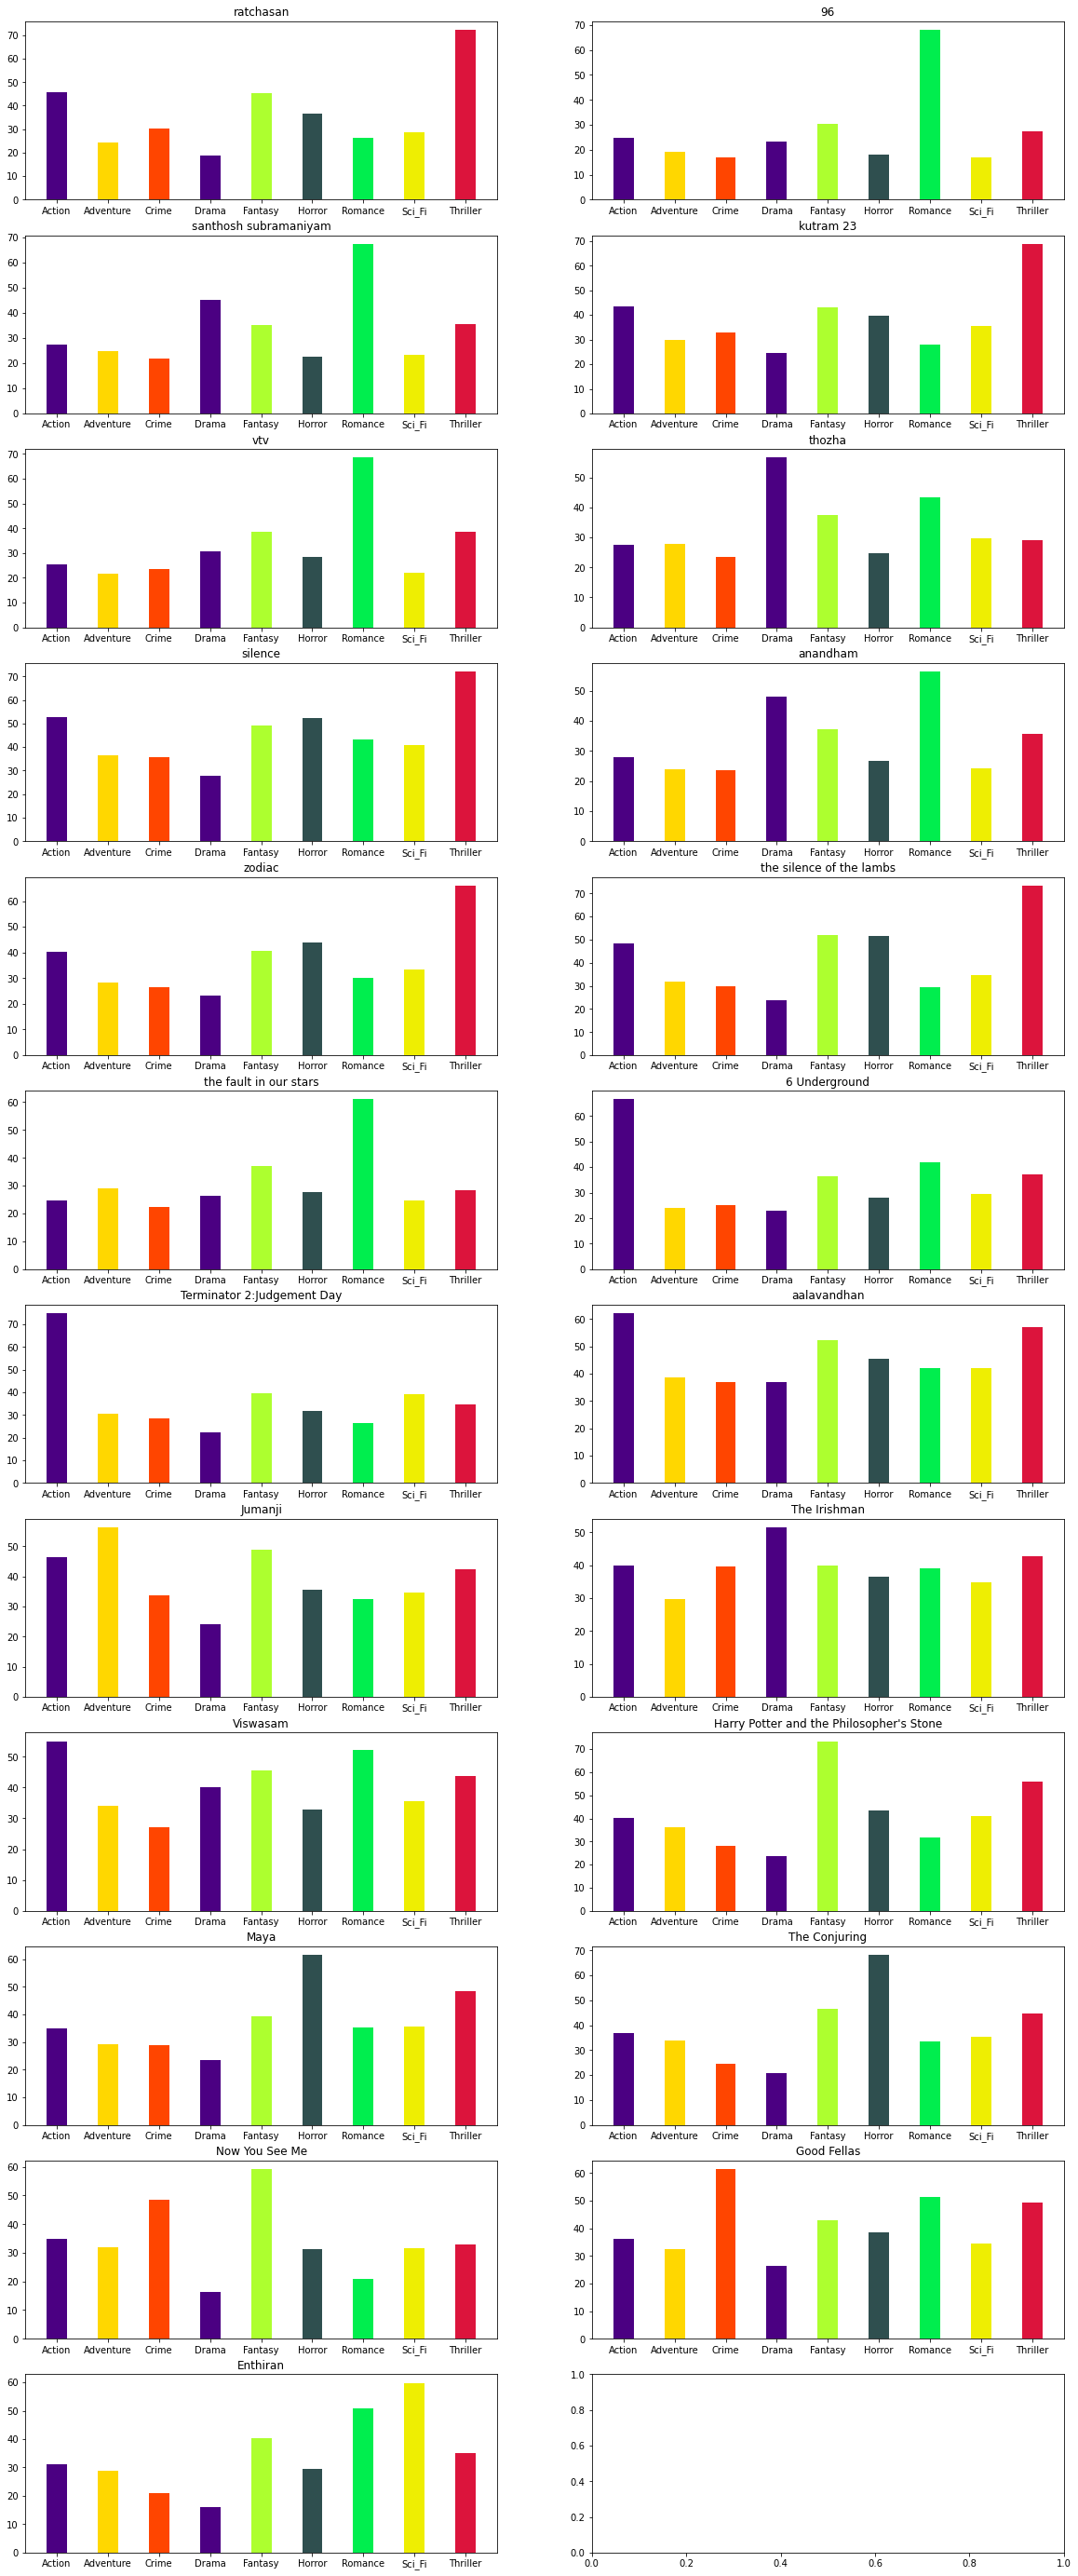

In [174]:
genre = ans.index.values
genre = [genre[i].title() for i in range(len(genre))]
fig, axs = plt.subplots(math.ceil(ans.shape[1]/2), 2,figsize = (20, 50))
count = 0
for i in ans.columns.values:
    nsix = ans[i] * 100
    axs[(count//2),count%2].bar(genre,nsix.values,color =color, width = 0.4)
    axs[(count//2),count%2].set_title(i)
    count+=1
plt.show()

In [35]:
pl = inp[inp.shape[0]-1:]['Plot_reduction'].values[0]
ti = inp[inp.shape[0]-1:]['title'].values[0]
ans = func5([pl],[ti])

In [36]:
ans

,Shutter Island
action,0.396126
adventure,0.290744
crime,0.280192
drama,0.227438
fantasy,0.421057
horror,0.407919
romance,0.248139
sci_fi,0.351235
thriller,0.757092


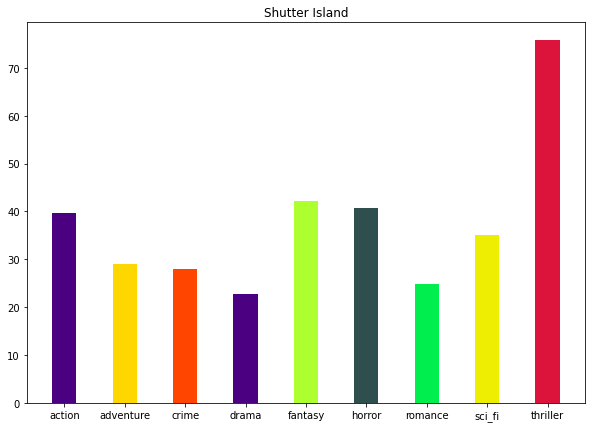

In [40]:
fig = plt.figure(figsize = (10, 7))
nsix = ans[ti].values*100
plt.bar(genre_nm,nsix,color = color, width = 0.4)
plt.title(ti)
plt.show()


In [38]:
pl = inp.iloc[23]['Plot_reduction']
ti = inp.iloc[23]['title']

In [28]:
ans = func5([pl],[ti])

In [29]:
ans

,Enthiran
action,0.311719
adventure,0.289319
crime,0.208363
drama,0.160400
fantasy,0.404438
horror,0.294726
romance,0.507992
sci_fi,0.598373
thriller,0.351287


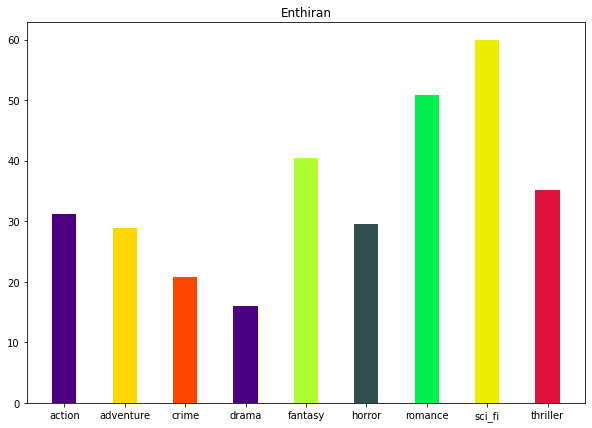

In [30]:
fig = plt.figure(figsize = (10, 7))
nsix = ans[ti].values*100
plt.bar(genre_nm,nsix,color = color, width = 0.4)
plt.title(ti)
plt.show()

In [32]:
inp['title']

0                                    ratchasan
1                                           96
2                        santhosh subramaniyam
3                                    kutram 23
4                                          vtv
5                                       thozha
6                                      silence
7                                     anandham
8                                       zodiac
9                     the silence of the lambs
10                      the fault in our stars
11                               6 Underground
12                  Terminator 2:Judgement Day
13                                 aalavandhan
14                                     Jumanji
15                                The Irishman
16                                    Viswasam
17    Harry Potter and the Philosopher's Stone
18                                        Maya
19                               The Conjuring
20                              Now You See Me
21           

In [35]:
inp

,title,genre,Plot_reduction
0,ratchasan,thriller,open old found brutal murder wrap aspir want m...
1,96,romance,visit high overcom arrang catch hesitantli lov...
2,santhosh subramaniyam,comedy/romance,rich manag live excess dote upon younger love ...
3,kutram 23,thriller,start confess murder abduct celebr anniversari...
4,vtv,romance,fall meet white got know older tri interact af...
5,thozha,drama,wealthi own leav ensur legal convey interest m...
6,silence,thriller,near mysteri murder crucifi take remain unsold...
7,anandham,drama,own provision eldest among four live togeth al...
8,zodiac,thriller,featur unknown surviv one later written call t...
9,the silence of the lambs,thriller,pull assign former incarcer cannibalist serial...
